# Plot Eval metrics

In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
from typing import Callable
import matplotlib as mpl
import numpy as np

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.promptloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.eval.eval_metric import evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams.update({
    # 'font.size': 8,
    # 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

load_dotenv()

True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative", use_cached: bool = True):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    res.append(get_results(f, all_ref_data, use_cached=use_cached))
                except Exception as e:
                    print(f"Error processing {str(f)}")
                    print(e)

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

In [4]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
# print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "Llama-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

In [5]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
  xlim: tuple = (0, 6),
  legend_rows: int = 2,
  save_png: bool = False,
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(12.5, 2 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for x_idx, (ax, (model, df)) in enumerate(zip(axs_y, results_df.groupby("model"))):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x="num_examples",
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                )

                # Remove ylabel
                # ax.set_ylabel("")
                # if x_idx == 0:
                #     ax.set_ylabel(metric)

                ax.yaxis.set_tick_params(labelbottom=True)
                
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(xlim)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // legend_rows,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.1, r'Conversation History Length $L$', ha='center')
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        if save_png:
            plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

In [6]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
        df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
    return df

In [7]:
def expectation_metrics(df: pd.DataFrame):
    """Calculte the sensitivity metrics of the responses
    
    These metrics are calculated as the expected value of the ratio of likelihoods.
    Further details can be found in the paper in Appendix E.
    We also mention the formulae in `likelihoods.py`
    """

    metrics_dict = {
        "base_likelihood": "exp_base",   # zero-shot sensitivity
        "final_likelihood": "exp_final", # confidence sensitivity
        "ref_likelihood": "exp_ref",     # loss sensitivity
    }
    assert all(m in df.columns for m in metrics_dict.keys()), f"Missing metrics: {metrics_dict.keys()}"

    for exp_metric in metrics_dict.values():
        df[exp_metric] = np.nan

    for row in df[
        [
            *metrics_dict.keys(),
            "model",
            "incontext_set",
        ]
    ].itertuples():
        for idx, metric in enumerate(metrics_dict.keys()):
            # Find the baseline metric
            baseline_metric = df[
                (df["model"] == row.model) & (df["num_examples"] == 0)
            ][metric].values
            # filter out None
            baseline_metric = [bm for bm in baseline_metric if not bm is None]
            if len(baseline_metric) > 0:
                base_log_likelihoods = np.array(baseline_metric[0])
            else:
                continue

            # Extract the row metric
            log_likelihoods = row[idx + 1]
            if log_likelihoods is None:
                continue

            log_likelihoods = np.array(log_likelihoods)

            # Assert that the lengths are the same
            assert len(base_log_likelihoods) == len(
                log_likelihoods
            ), f"Lengths of baseline and likelihood are different for {metric}"

            # Calculate the Expected [baseline_metric / metric]
            exp_likelihood = np.exp(base_log_likelihoods - log_likelihoods)
            exp_likelihood = np.log(exp_likelihood)
            exp_likelihood = np.mean(exp_likelihood)
            df.loc[row.Index, metrics_dict[metric]] = exp_likelihood
    return df

In [8]:
def results_latex_table(df: pd.DataFrame, columns: list[str], task: str, num_examples: int = 5):
    """Print a dataframe as a latex table
    
    Args:
      df: dataframe
      columns: list of columns to include
      task: name of the task (this is printed as the first set of rows)

    Format:
      dataset | model | metric1 | metric2 | ...
    """

    empty_char = r"$*$"
    # empty_char = r"{\tiny\boxedsymbols{✗}}"

    # Sort datasets
    datasets = sorted(list(df["incontext_set"].unique()))
    datasets.remove(task)
    datasets = [task] + datasets

    # Print header
    print("CH-Task & Model & {" + "} & {".join(columns) + r"} \\")
    print(r"\midrule")

    for dataset in datasets:
        print(f"{dataset_label[dataset]} ")
        df_ds = df[df["incontext_set"] == dataset]
        for model, df_model in df_ds.groupby("model"):
            # print model
            print(f"& {model_label[model]} & ", end="")
            # filter by number of examples
            df_model = df_model[df_model["num_examples"] == num_examples]
            # extract relevant columns
            try:
                values = df_model[columns].values[0]
                # print values
                # make italics if it's the task
                if dataset == task:
                    print(" & ".join([empty_char if np.isnan(v) else f"\emph{{{v:.2f}}}" for v in values]) + r" \\")
                else:
                    print(" & ".join([empty_char if np.isnan(v) else f"{v:.2f}" for v in values]) + r" \\")
            except IndexError:
                print(" & ".join([empty_char] * len(columns)) + r" \\")
            
        if dataset != datasets[-1]:
            print(r"\midrule")
        if dataset == task:
            print(r"\midrule")

In [9]:
def zero_shot_latex_table(
    df: pd.DataFrame, columns: list[str], task: str, num_examples: int = 0, fmts: None = None
):
    """Print a dataframe as a latex table (for zero-shot results)

    Args:
      df: dataframe
      columns: list of columns to include
      task: name of the task (this is printed as the first set of rows)

    Format:
      model | metric1 | metric2 | ...
    """
    # Sort datasets
    # datasets = sorted(list(df["incontext_set"].unique()))
    # datasets.remove(task)
    # datasets = [task] + datasets

    # Set string formatting
    if fmts is None:
        fmts = [".2f"] * len(columns)

    # Print header
    print("Model & {" + "} & {".join(columns) + r"} \\")
    print(r"\midrule")

    # filter by number of examples
    df = df[df["num_examples"] == num_examples]
    # filter by task dataset
    df = df[df["incontext_set"] == task]

    for model, df_model in df.groupby("model"):
        # print model
        print(f"{model_label[model]} & ", end="")
        # extract relevant columns
        try:
            values = df_model[columns].values[0]
            # print values            
            print(
                " & ".join(
                    ["{-}" if np.isnan(v) else f"{v:{fmt}}" for v, fmt in zip(values, fmts)]
                )
                + r" \\"
            )
        except IndexError:
            print(" & ".join(["{-}"] * len(columns)) + r" \\")

## Evaluate on Rotten Tomatoes

In [ ]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset("rotten_tomatoes", rt_reference_data, use_cached=True)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

In [36]:
# Calculate the percentage change in accuracy
rt_results_df["acc"] = rt_results_df["matches"] / rt_results_df["total"]
rt_results_df = df_metric_pct_change(rt_results_df, "acc")

# Calculate sensitivity
# rt_results_df = sensitivity(rt_results_df)
rt_results_df = expectation_metrics(rt_results_df)

# remove incontext_set dailymail
rt_results_df = rt_results_df[rt_results_df["incontext_set"] != "dailymail"]

rt_results_df.head()

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,acc,acc_pct_change,exp_base,exp_final,exp_ref
3,970,0,1066,mistral-7b,rotten_tomatoes,10,None,None,None,0.909944,4.978355,NaN,NaN,NaN
4,959,2,1066,mistral-7b,rotten_tomatoes,6,"[-4.686050891876221, -4.661656856536865, -5.04...",None,None,0.899625,3.787879,0.678534,NaN,NaN
5,924,1,1066,mistral-7b,rotten_tomatoes,0,"[-4.045590400695801, -4.0538763999938965, -4.0...","[-4.045590400695801, -4.0538763999938965, -4.0...","[-4.220350742340088, -4.32817268371582, -4.091...",0.866792,0.000000,0.000000,0.0,0.0
6,956,1,1066,mistral-7b,rotten_tomatoes,4,"[-4.320728302001953, -4.697839260101318, -5.21...",None,None,0.896811,3.463203,0.728106,NaN,NaN
7,943,0,1066,mistral-7b,rotten_tomatoes,2,"[-4.356719970703125, -4.619098663330078, -4.77...",None,None,0.884615,2.056277,0.595756,NaN,NaN


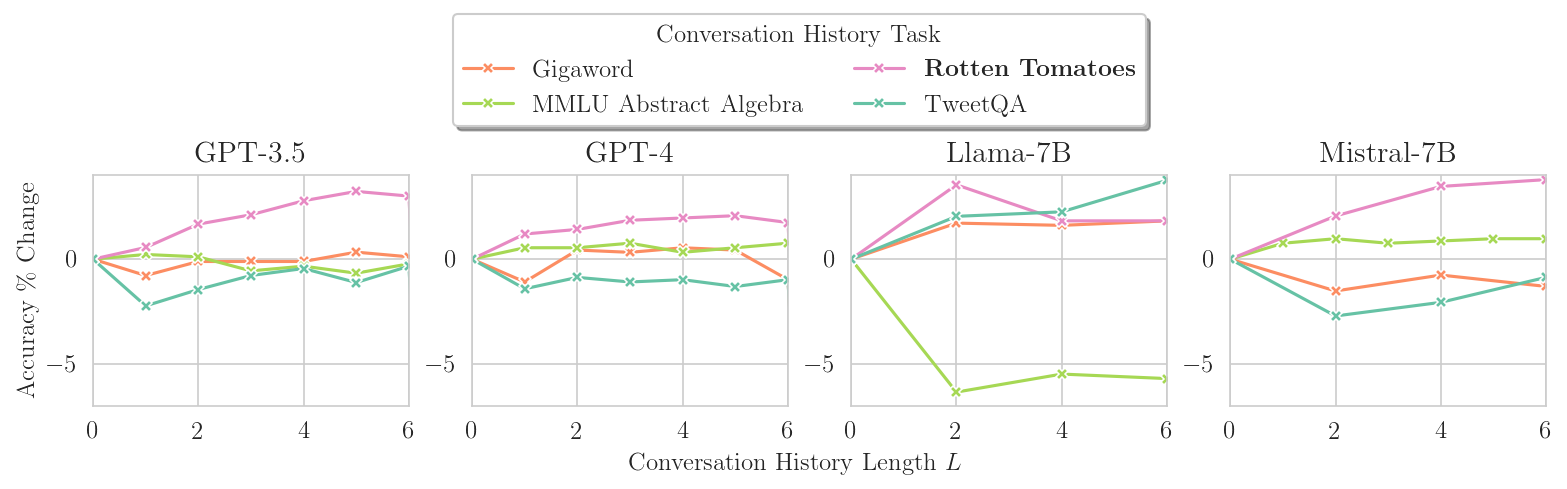

In [39]:
label = r"Accuracy \% Change"
df = rt_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.75),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 2),
  save_png=True,
)

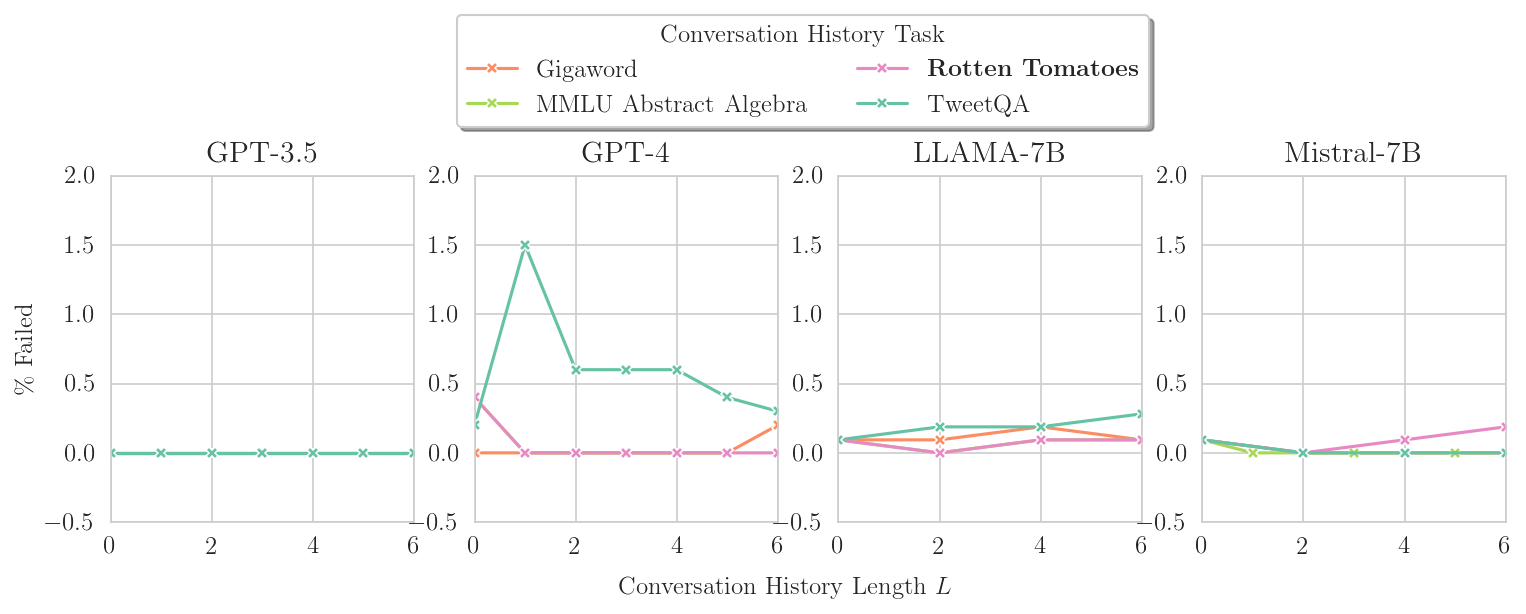

In [ ]:
rt_results_df["perc_fail"] = rt_results_df["failed"] / rt_results_df["total"] * 100
df = rt_results_df.rename(columns={"perc_fail": r"\% Failed"})
plot_df_metrics_per_model(
  df, 
  [r"\% Failed"], 
  save_path=Path("rt/fail_rate.pdf"), 
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.5),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-0.5, 2),
  legend_axs=(-1, 2),
)

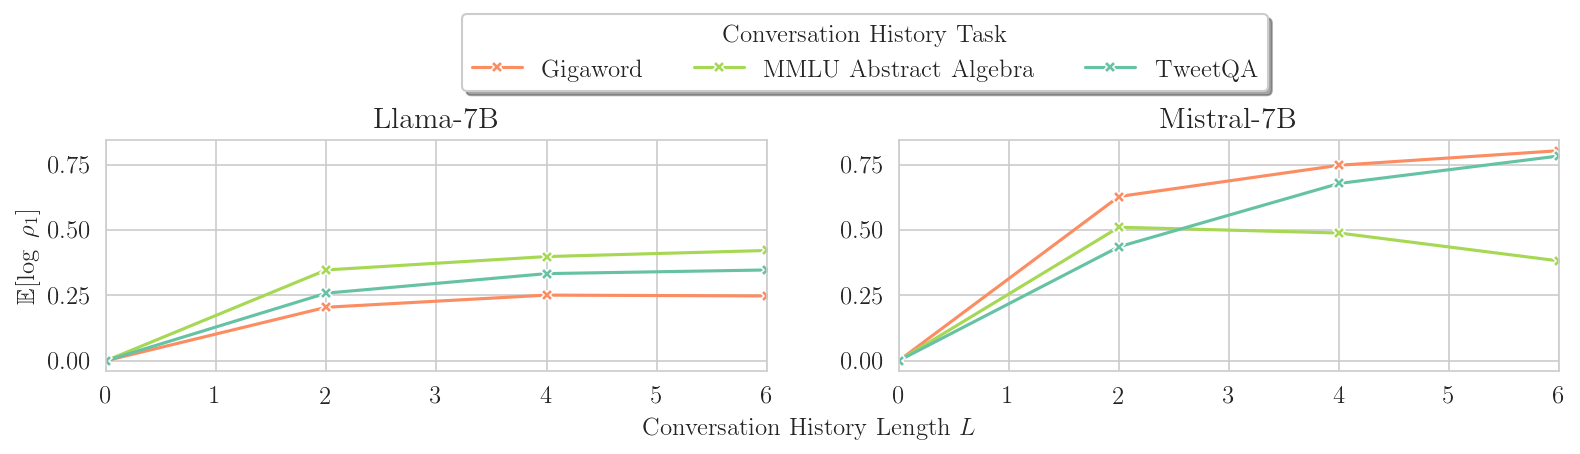

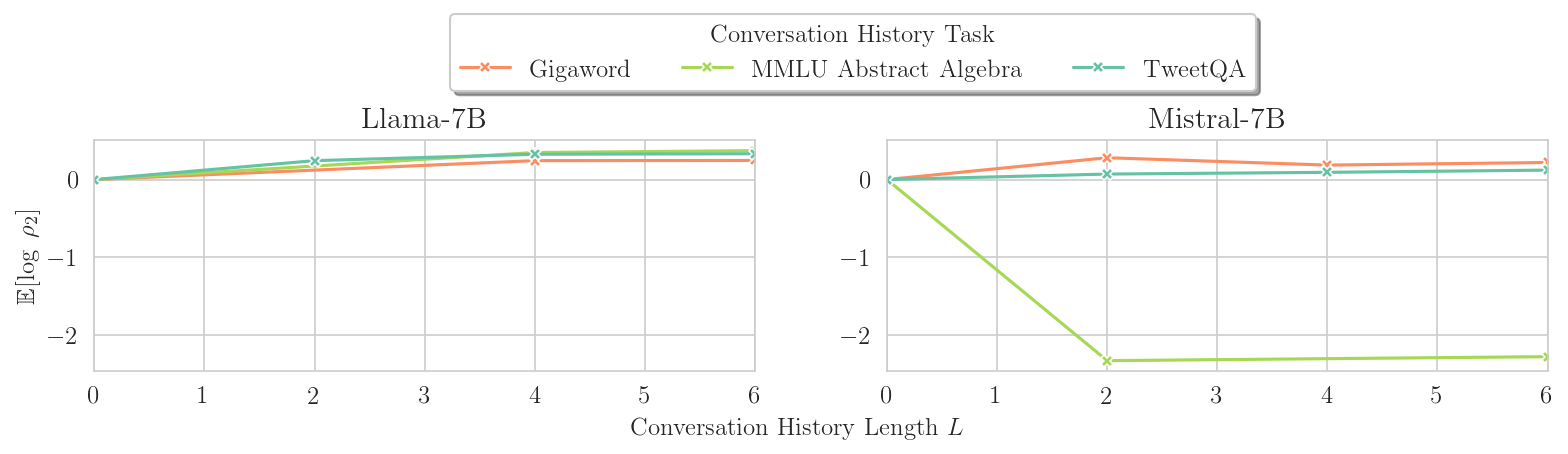

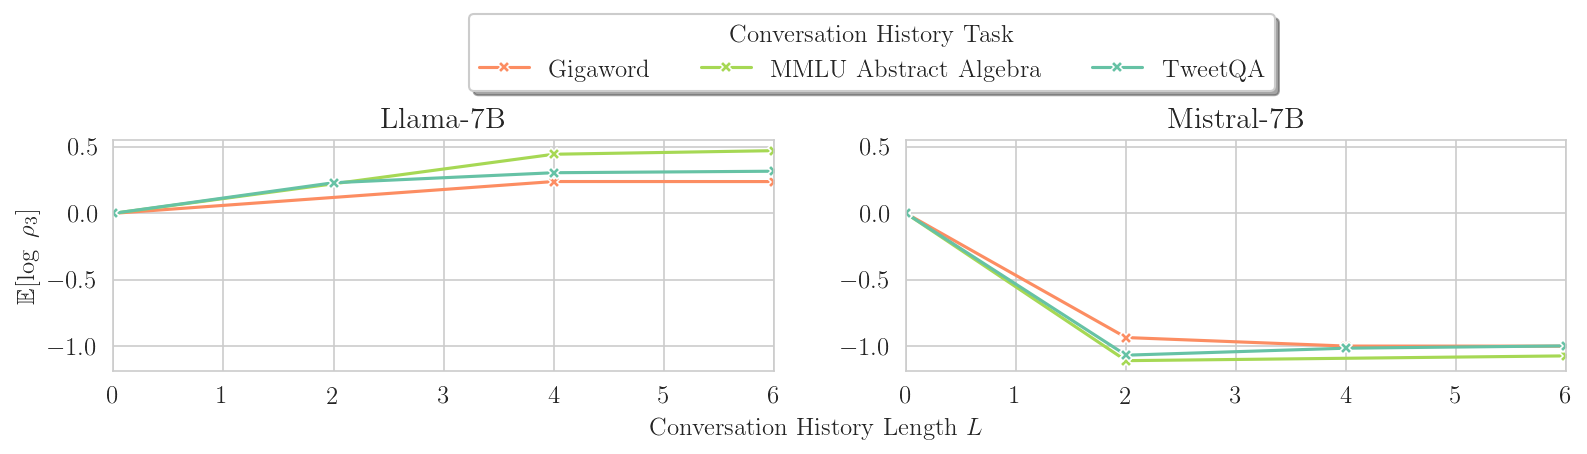

In [41]:
# aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
# df = aa_results_df.rename(columns={"sensitivity": label})
df = rt_results_df

columns = {
  "exp_base": r"$\mathbb{E}[\log \ \rho_1]$",
  "exp_final": r"$\mathbb{E}[\log \ \rho_2]$",
  "exp_ref": r"$\mathbb{E}[\log \ \rho_3]$"
}
df = df.rename(columns=columns)
# label = r"Sensitivity $\tau$"
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]

# remove mmluaa
df = df[df["incontext_set"] != "rotten_tomatoes"]
df = expectation_metrics(df)

# df = df.rename(columns={"exp_base": label})
for key, col in columns.items():
  plot_df_metrics_per_model(
    df, 
    [col], 
    save_path=Path(f"rt/{key}.pdf"), 
    # title="MMLU Abstract Algebra Results",
    # eval_set="rotten_tomatoes",
    legend_anchor=(0.52, 1.6),
    legend_rows=1,
    save_png=True,
  )

In [ ]:
# Zero shot results table

df = rt_results_df

columns = {
    "acc": "Accuracy",
    "failed": r"\# Format Errors",
}
df = df.rename(columns=columns)

# Multiple accuracy by 100
df["Accuracy"] *= 100
# round to 2 decimal places
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x, 2))

zero_shot_latex_table(
    df,
    columns=columns.values(),
    task="rotten_tomatoes",
    num_examples=0,
    fmts=[".2f", ".0f"],
)

Model & {Accuracy} & {\# Format Errors} \\
\midrule
GPT-3.5 & 89.90 & 0 \\
GPT-4 & 91.80 & 4 \\
LLAMA-7B & 87.43 & 1 \\
Mistral-7B & 86.68 & 1 \\


In [ ]:
# Main Results Table

df = rt_results_df

# remove in_context dailymail
df = df[~((df["incontext_set"] == "dailymail"))]
columns={
    r"acc_pct_change": r"\% Change",
    r"exp_base": r"$\tau(\cdot)$",
}

df = df.rename(columns=columns)

results_latex_table(
    df,
    columns.values(),
    task="rotten_tomatoes",
    num_examples=6,
)

CH-Task & Model & {\% Change} & {$\tau(\cdot)$} \\
\midrule
Rotten Tomatoes 
& GPT-3.5 & \emph{3.00} & $*$ \\
& GPT-4 & \emph{1.74} & $*$ \\
& LLAMA-7B & \emph{1.82} & \emph{4.02} \\
& Mistral-7B & \emph{3.79} & \emph{2.65} \\
\midrule
\midrule
Gigaword 
& GPT-3.5 & 0.11 & $*$ \\
& GPT-4 & -0.98 & $*$ \\
& LLAMA-7B & 1.82 & 1.98 \\
& Mistral-7B & -1.30 & 3.04 \\
\midrule
MMLU Abstract Algebra 
& GPT-3.5 & -0.22 & $*$ \\
& GPT-4 & 0.76 & $*$ \\
& LLAMA-7B & -5.69 & 3.37 \\
& Mistral-7B & 0.97 & 1.39 \\
\midrule
TweetQA 
& GPT-3.5 & -0.33 & $*$ \\
& GPT-4 & -0.98 & $*$ \\
& LLAMA-7B & 3.76 & 2.77 \\
& Mistral-7B & -0.87 & 3.01 \\


### Evaluate on MMLU Human Ageing

In [10]:
mmlu_age = MMLUHumanAgingDataLoader()
mmlu_age_ref_data = mmlu_age.load_test_reference()
mmlu_age_results = get_results_for_evalset(
    "mmlu-age", mmlu_age_ref_data, use_cached=False
)
mmlu_age_df = pd.DataFrame(mmlu_age_results)
print(len(mmlu_age_df))
mmlu_age_df.head()

Removing large training set examples
Original training set size:  26
New Training set size:  26
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmlu-age/incontext_data_mmlu-age/num_examples_3/iterative/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmlu-age/incontext_data_mmlu-age/num_examples_3/iterative/ref_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmlu-age/incontext_data_mmlu-age/num_examples_6/iterative/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmlu-age/incontext_data_mmlu-age/num_examples_6/iterative/ref_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmlu-age/incontext_data_mmlu-age/num_examples_0/iterative/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmlu-age/incontext_data_mmlu-age/num_examples_0/iterative/re

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood
0,137,1,222,mistral-7b,mmlu-age,3,"[-0.7274147272109985, -1.3350273370742798, -1....",None,None
1,138,2,222,mistral-7b,mmlu-age,6,"[-0.7438650131225586, -1.300289511680603, -1.1...",None,None
2,123,0,222,mistral-7b,mmlu-age,0,"[-0.45550537109375, -1.1860079765319824, -1.09...",None,None
3,140,1,222,mistral-7b,mmlu-age,4,"[-0.6973514556884766, -1.3394109010696411, -1....",None,None
4,135,1,222,mistral-7b,mmlu-age,2,"[-0.6563717722892761, -1.2342803478240967, -1....",None,None


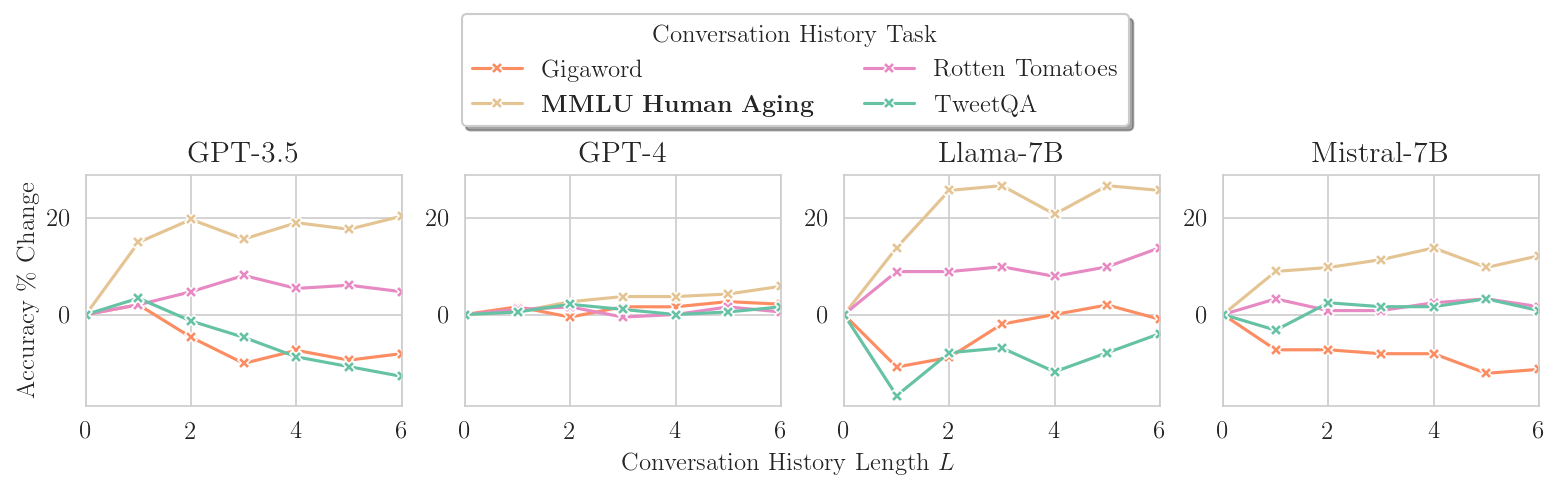

In [27]:
mmlu_age_df["acc"] = mmlu_age_df["matches"] / mmlu_age_df["total"]
mmlu_age_df = df_metric_pct_change(mmlu_age_df, "acc")
df = mmlu_age_df.rename(columns={"acc_pct_change": r"Accuracy \% Change"})
plot_df_metrics_per_model(
  df, 
  [r"Accuracy \% Change"], 
  save_path=Path("mmlu-age/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_axs=(-1, 1),
  legend_anchor=(-0.05, 1.75),
  save_png=True,
)

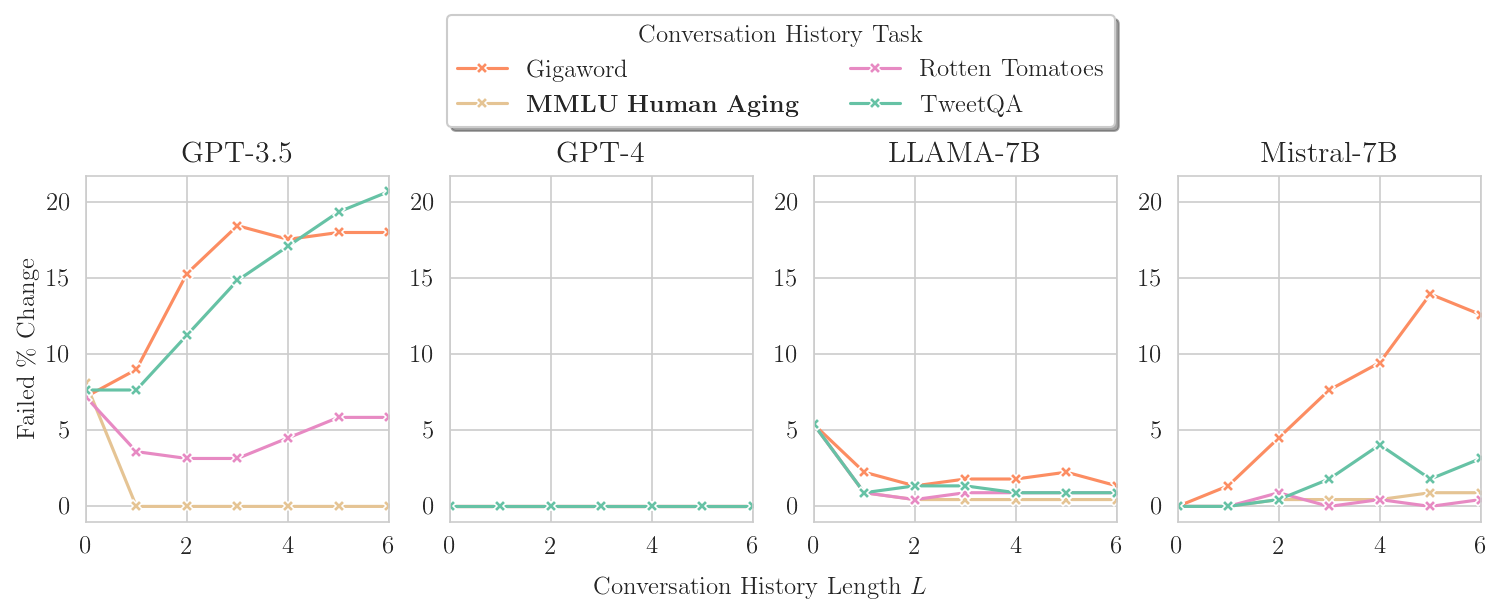

In [ ]:
df = mmlu_age_df
df["perc_fail"] = df["failed"] / df["total"] * 100
df = df.rename(columns={"perc_fail": r"Failed \% Change"})
plot_df_metrics_per_model(
  df, 
  [r"Failed \% Change"], 
  save_path=Path("mmlu-age/fail_rate.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_axs=(-1, 1),
  legend_anchor=(-0.05, 1.5),
)

In [74]:
# zero shot results
df = mmlu_age_df

columns = {
    "acc": "Accuracy",
    "failed": r"\# Format Errors",
}
df = df.rename(columns=columns)

# Multiple accuracy by 100
df["Accuracy"] *= 100
# round to 2 decimal places
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x, 2))

zero_shot_latex_table(
    df,
    columns=columns.values(),
    task="mmlu-age",
    num_examples=0,
    fmts=[".2f", ".0f"],
)

Model & {Accuracy} & {\# Format Errors} \\
\midrule
GPT-3.5 & 66.22 & 18 \\
GPT-4 & 84.68 & 0 \\
LLAMA-7B & 45.50 & 12 \\
Mistral-7B & 55.41 & 0 \\


## Evaluate on MMLUAA

In [11]:
aa = MMLUAbstractAlgebraDataLoader()
aa_ref_data = aa.load_test_reference()
aa_results = get_results_for_evalset("mmluaa", aa_ref_data, use_cached=False)
aa_results_df = pd.DataFrame(aa_results)

print(len(aa_results_df))
aa_results_df.head()

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

---Failed for Answer: a, true
: Reference: B, ['true, true', 'true, false', 'false, true']:
Prediction:  <Answer> A, True </Answer>
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/ref_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_4/iterative/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_4/iterative/ref_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_2/iterative/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood
0,23,1,99,mistral-7b,rotten_tomatoes,3,"[-1.182308316230774, -1.2521668672561646, -1.2...",None,None
1,26,0,99,mistral-7b,rotten_tomatoes,6,"[-1.1793919801712036, -1.2439383268356323, -1....","[-1.1793919801712036, -1.0642398595809937, -1....","[-3.2466354370117188, -3.2630538940429688, -3...."
2,22,0,99,mistral-7b,rotten_tomatoes,0,"[-1.1537379026412964, -1.2377865314483643, -1....","[-1.1537379026412964, -1.2377865314483643, -1....","[-3.360292911529541, -3.3725922107696533, -3.2..."
3,26,0,99,mistral-7b,rotten_tomatoes,4,"[-1.2010455131530762, -1.223287582397461, -1.2...",None,None
4,24,0,99,mistral-7b,rotten_tomatoes,2,"[-1.1443839073181152, -1.2271956205368042, -1....",None,None


In [12]:
aa_results_df["acc"] = aa_results_df["matches"] / aa_results_df["total"]
aa_results_df = df_metric_pct_change(aa_results_df, "acc")
aa_results_df = expectation_metrics(aa_results_df)

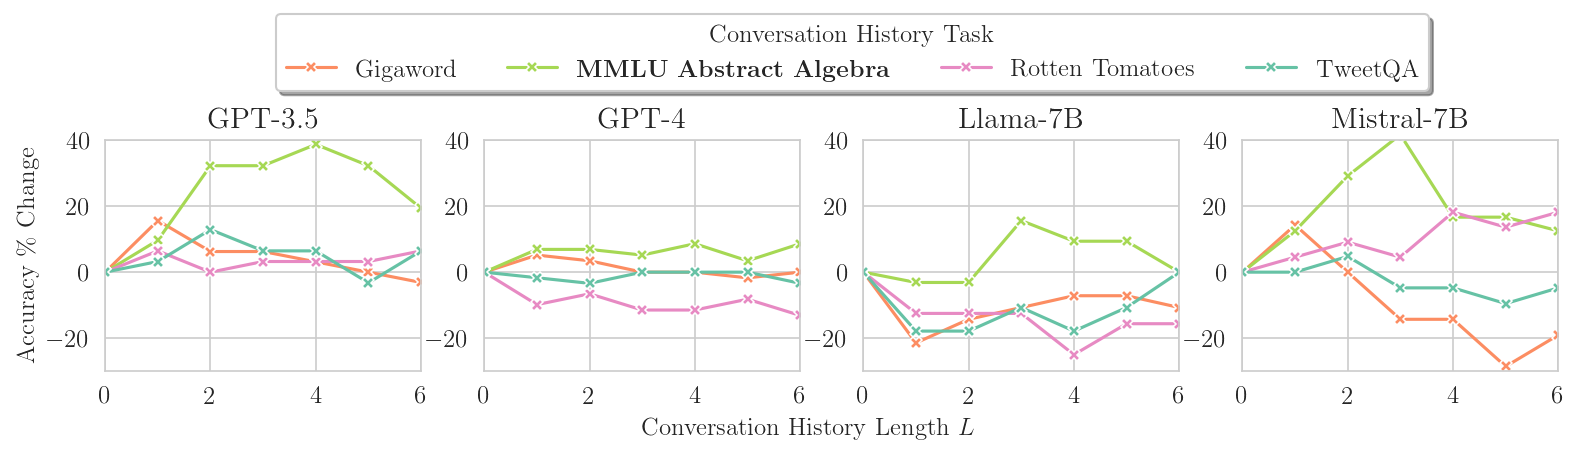

In [13]:
label = r"Accuracy \% Change"

df = aa_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("mmluaa/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  legend_anchor=(0.5, 1.6),
  eval_set="mmluaa",
  legend_rows=1,
  adjust_func=lambda axs: axs[0,0].set_ylim(-30, 40),
  save_png=True,
)

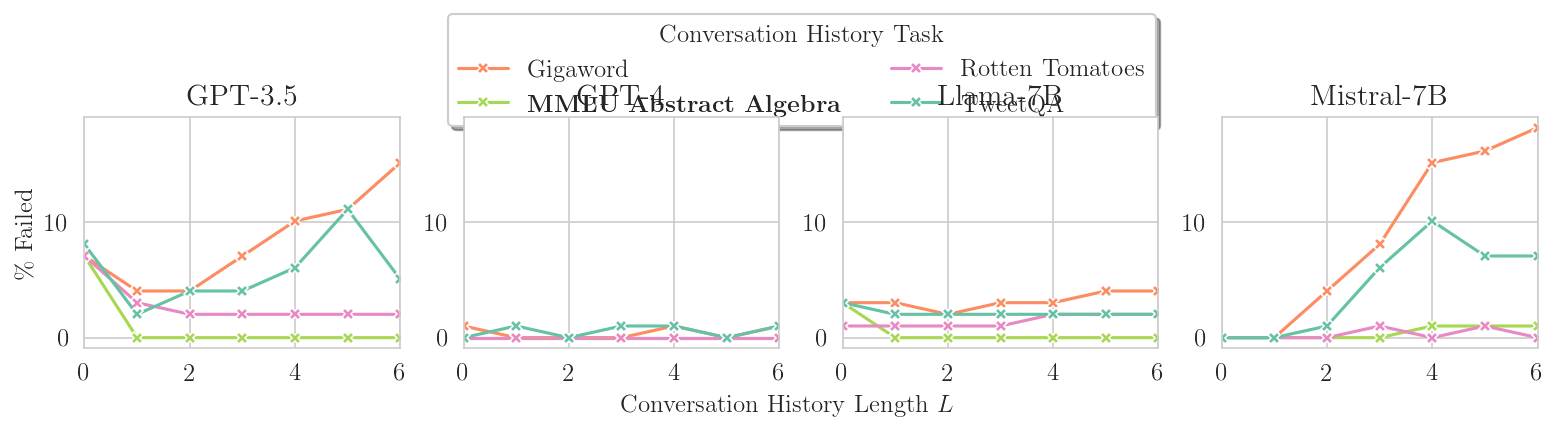

In [54]:
aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
df = aa_results_df.rename(columns={"perc_fail": r"\% Failed"})
plot_df_metrics_per_model(
  df, 
  [r"\% Failed"], 
  save_path=Path("mmluaa/fail_rate.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(1.11, 1.5),
)

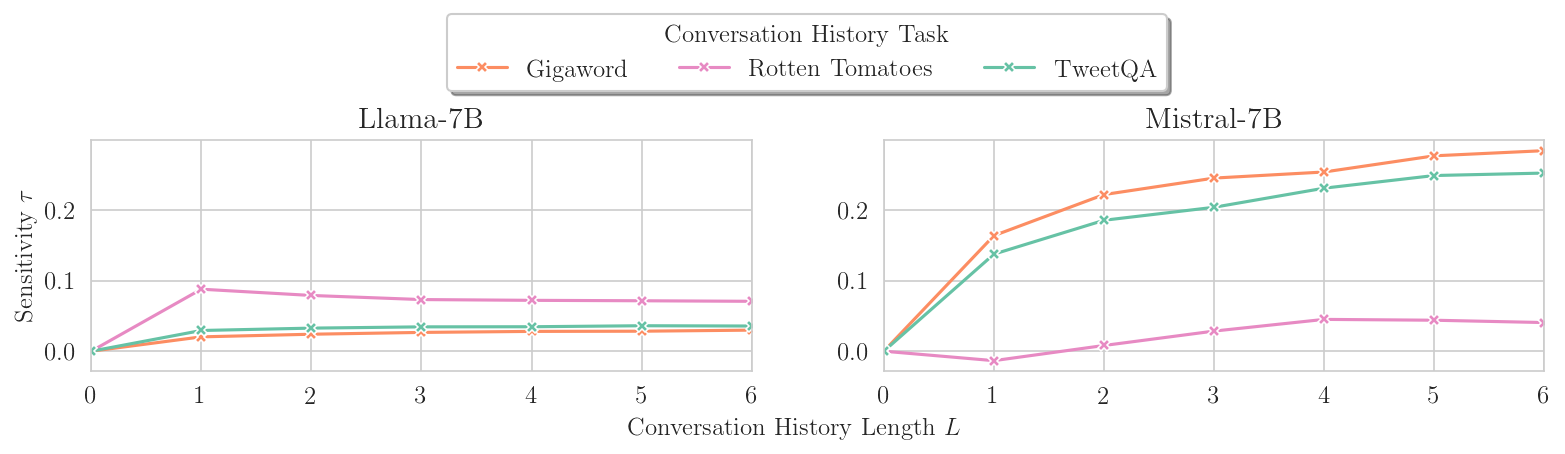

In [59]:
df = aa_results_df

columns = {
    "exp_base": r"Sensitivity $\tau$",
    # "exp_final": r"$\mathbb{E}[\log \ \rho_2]$",
    # "exp_ref": r"$\mathbb{E}[\log \ \rho_3]$",
}
df = df.rename(columns=columns)
# label = r"Sensitivity $\tau$"
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]

# remove mmluaa
df = df[df["incontext_set"] != "mmluaa"]
df = expectation_metrics(df)

# df = df.rename(columns={"exp_base": label})
for col in columns.values():
    plot_df_metrics_per_model(
        df,
        [col],
        save_path=Path("mmluaa/sensitivity.pdf"),
        # title="MMLU Abstract Algebra Results",
        eval_set="mmluaa",
        legend_anchor=(0.52, 1.6),
        legend_rows=1,
        save_png=True,
    )

In [31]:
# Results table

df = aa_results_df
df = df.rename(
    columns={
        r"exp_base": r"$\tau(\cdot)$",
        r"acc_pct_change": r"\% Change",
    }
)
results_latex_table(
    df,
    [r"\% Change", r"$\tau(\cdot)$"],
    task="mmluaa",
    num_examples=6,
)

CH-Task & Model & {\% Change} & {$\tau(\cdot)$} \\
\midrule
MMLU Abstract Algebra 
& GPT-3.5 & \emph{19.35} & $*$ \\
& GPT-4 & \emph{8.62} & $*$ \\
& LLAMA-7B & \emph{3.57} & \emph{31.51} \\
& Mistral-7B & \emph{28.57} & \emph{1.12} \\
\midrule
\midrule
Gigaword 
& GPT-3.5 & -3.13 & $*$ \\
& GPT-4 & 0.00 & $*$ \\
& LLAMA-7B & -10.71 & 5.23 \\
& Mistral-7B & -19.05 & 3.13 \\
\midrule
Rotten Tomatoes 
& GPT-3.5 & 6.45 & $*$ \\
& GPT-4 & -13.11 & $*$ \\
& LLAMA-7B & -15.63 & 9.91 \\
& Mistral-7B & 18.18 & 0.83 \\
\midrule
TweetQA 
& GPT-3.5 & 6.45 & $*$ \\
& GPT-4 & -3.39 & $*$ \\
& LLAMA-7B & 0.00 & 6.37 \\
& Mistral-7B & -4.76 & 2.78 \\


In [81]:
# Zero shot results on MMLU Abstract Algebra

df = aa_results_df

columns = {
    "acc": "Accuracy",
    "failed": r"\# Format Errors",
}
df = df.rename(columns=columns)

# Multiple accuracy by 100
df["Accuracy"] *= 100
# round to 2 decimal places
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x, 2))

zero_shot_latex_table(
    df,
    columns=columns.values(),
    task="mmluaa",
    num_examples=0,
    fmts=[".2f", ".0f"],
)

Model & {Accuracy} & {\# Format Errors} \\
\midrule
GPT-3.5 & 31.31 & 7 \\
GPT-4 & 58.59 & 0 \\
LLAMA-7B & 28.28 & 3 \\
Mistral-7B & 21.21 & 0 \\


## Evaluate on TweetQA

In [ ]:
tq = TweetQADataLoader()
tq_reference_data = tq.load_test_reference()
tq_results = get_results_for_evalset("tweetqa", tq_reference_data, use_cached=True)
# convert to dataframe
tq_results_df = pd.DataFrame.from_records(tq_results)
# df = df.sort_values("num_examples")

In [48]:
# Remove the incontext dailymail
tq_results_df = tq_results_df[~((tq_results_df["incontext_set"] == "dailymail"))]
tq_results_df.head()

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples,base_likelihood
6,0.297130,0.154791,0.294580,0.295140,0.439794,mistral-7b,rotten_tomatoes,10,None
7,0.303190,0.154953,0.301082,0.301396,0.438071,mistral-7b,rotten_tomatoes,6,None
8,0.252482,0.125936,0.249639,0.250563,0.407057,mistral-7b,rotten_tomatoes,0,None
9,0.308775,0.158008,0.306632,0.306662,0.440724,mistral-7b,rotten_tomatoes,4,None
10,0.312676,0.159910,0.309786,0.310221,0.438143,mistral-7b,rotten_tomatoes,2,None


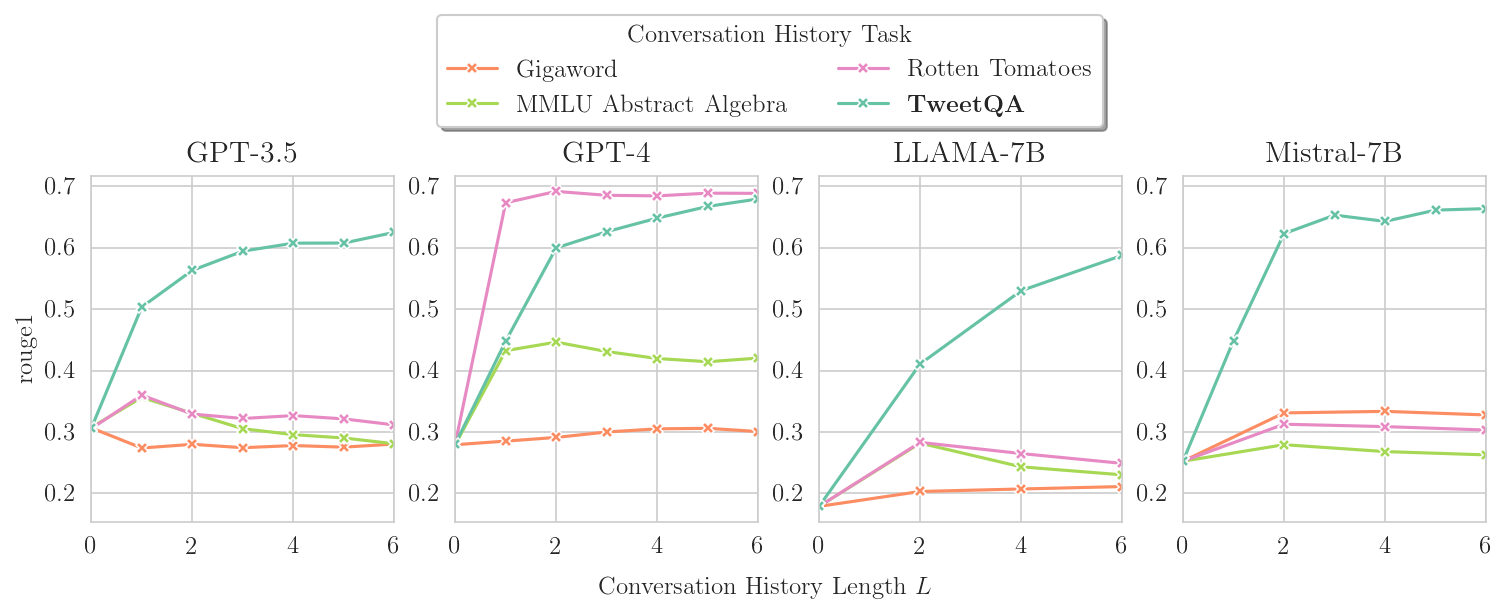

In [92]:
plot_df_metrics_per_model(
  tq_results_df, 
  ["rouge1"], 
  eval_set="tweetqa",
  legend_anchor=(-1.3, 1.5),
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 2),
)

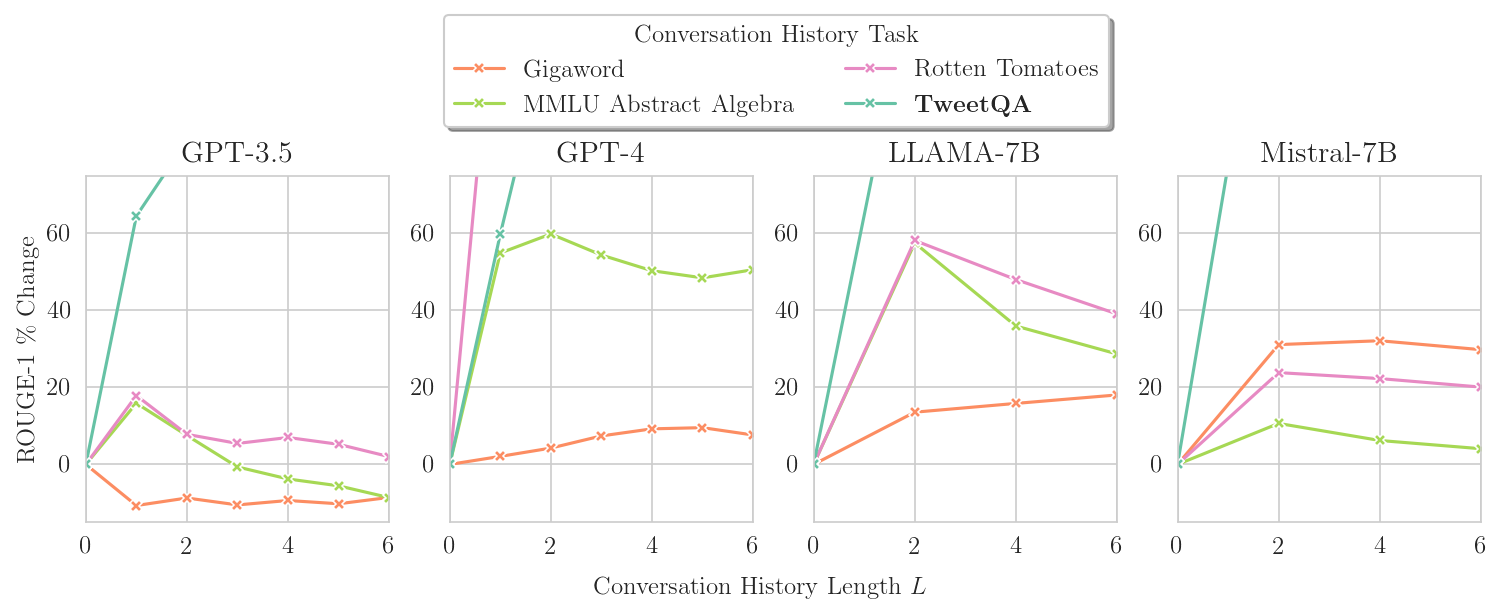

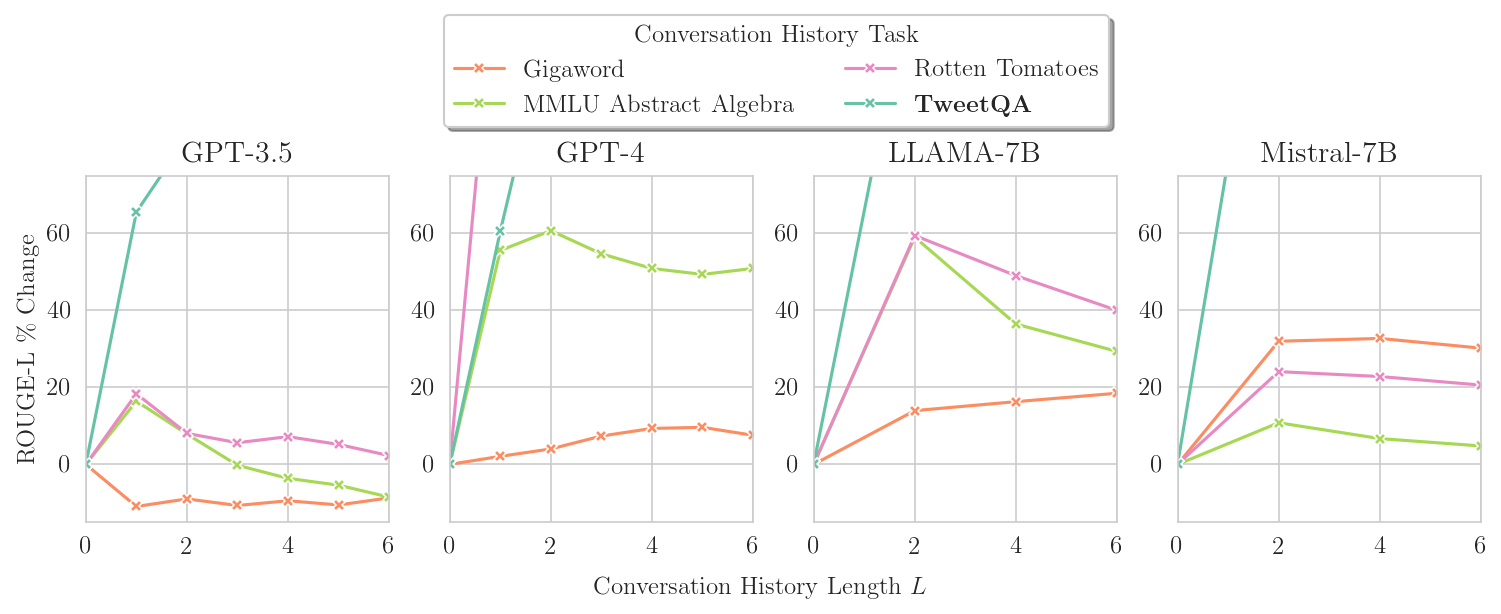

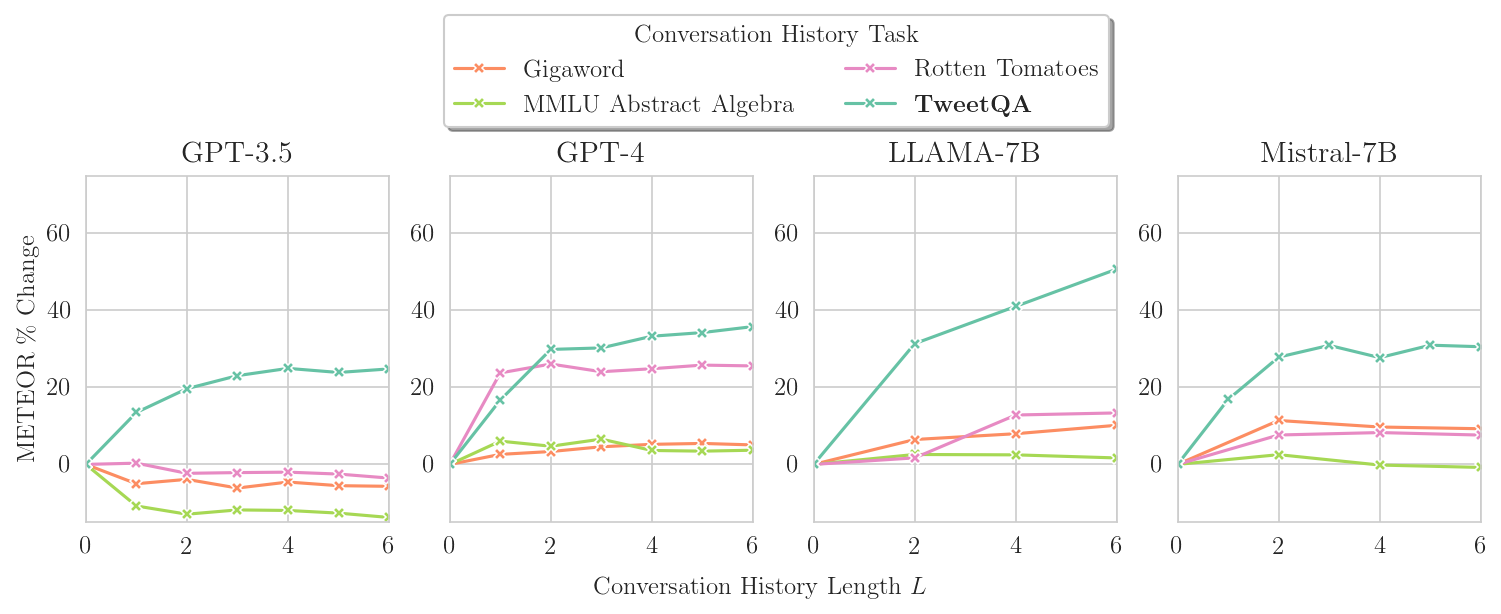

In [94]:
# Plot percentage change in metrics (1 graph per metric)

df = tq_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rougeL")
df = df_metric_pct_change(df, "meteor")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
    "meteor_pct_change": r"METEOR \% Change",
}

df = df.rename(columns=labels)

for metric in labels.values():
    plot_df_metrics_per_model(
        df,
        [metric],
        save_path=Path(f"tweetqa/{metric.split()[0]}.pdf"),
        eval_set="tweetqa",
        legend_anchor=(1.14, 1.5),
        adjust_func=lambda axs: axs[0, 0].set_ylim(-15, 75),
        legend_axs=(0, 0),
    )

In [96]:
# Zero shot results table

df = tq_results_df

columns = {
    "rouge1": "ROUGE-1",
    "rougeL": "ROUGE-L",
    "meteor": "METEOR",
}
df = df.rename(columns=columns)

for col in columns.values():
    df[col] = df[col] * 100

zero_shot_latex_table(df, columns=columns.values(), task="tweetqa", num_examples=0)


Model & {ROUGE-1} & {ROUGE-L} & {METEOR} \\
\midrule
GPT-3.5 & 30.59 & 30.35 & 44.18 \\
GPT-4 & 28.02 & 27.72 & 43.41 \\
LLAMA-7B & 17.90 & 17.63 & 33.84 \\
Mistral-7B & 25.25 & 24.96 & 40.71 \\


## Gigaword set

In [ ]:
gw = GigawordDataLoader()
gw_reference_data = gw.load_test_reference()
gw_results = get_results_for_evalset("gigaword", gw_reference_data, use_cached=True)

In [48]:
gw_results_df = pd.DataFrame.from_records(gw_results)
print(len(gw_results_df))

# remove in_context dailymail
gw_results_df = gw_results_df[~((gw_results_df["incontext_set"] == "dailymail"))]

gw_results_df.head()

135


,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples,base_likelihood
6,0.188080,0.054284,0.160740,0.160751,197.596617,mistral-7b,rotten_tomatoes,10,NaN
7,0.190086,0.055322,0.162274,0.162257,193.060994,mistral-7b,rotten_tomatoes,6,NaN
8,0.185710,0.051803,0.158150,0.158175,203.721681,mistral-7b,rotten_tomatoes,0,NaN
9,0.191853,0.056348,0.164331,0.164319,190.101486,mistral-7b,rotten_tomatoes,4,NaN
10,0.196036,0.057439,0.167680,0.167576,185.599692,mistral-7b,rotten_tomatoes,2,NaN


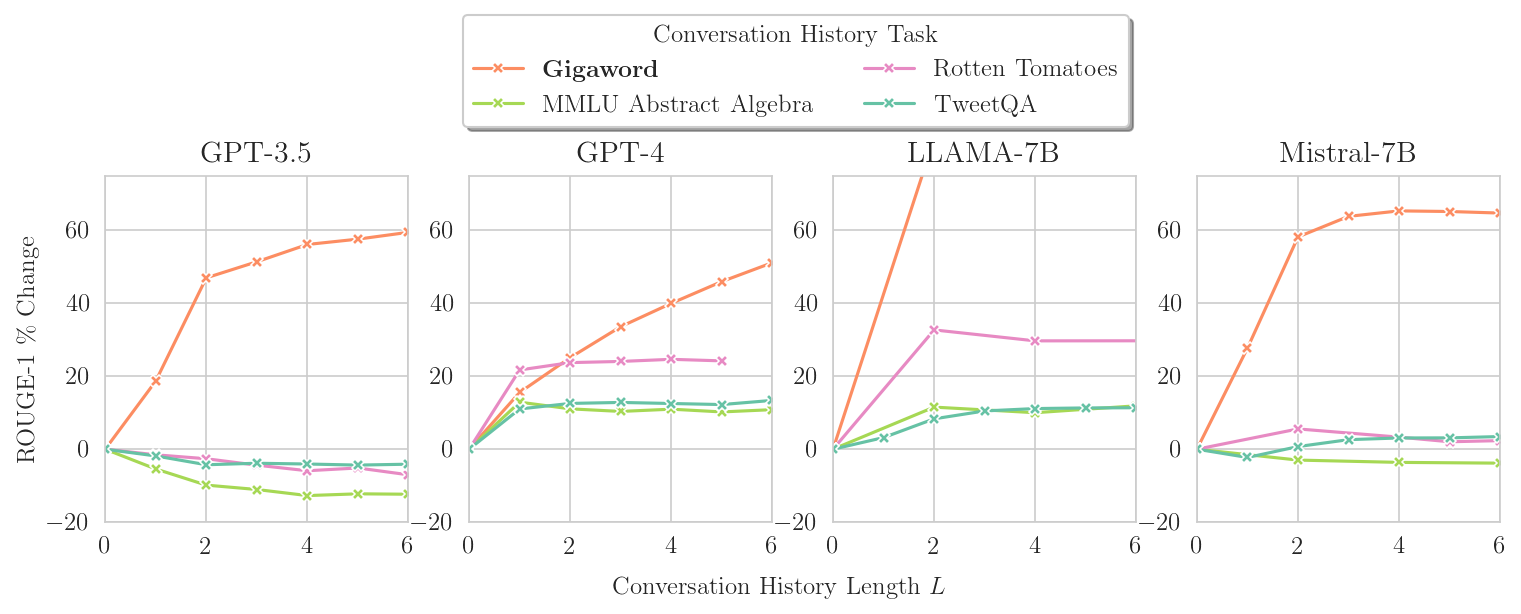

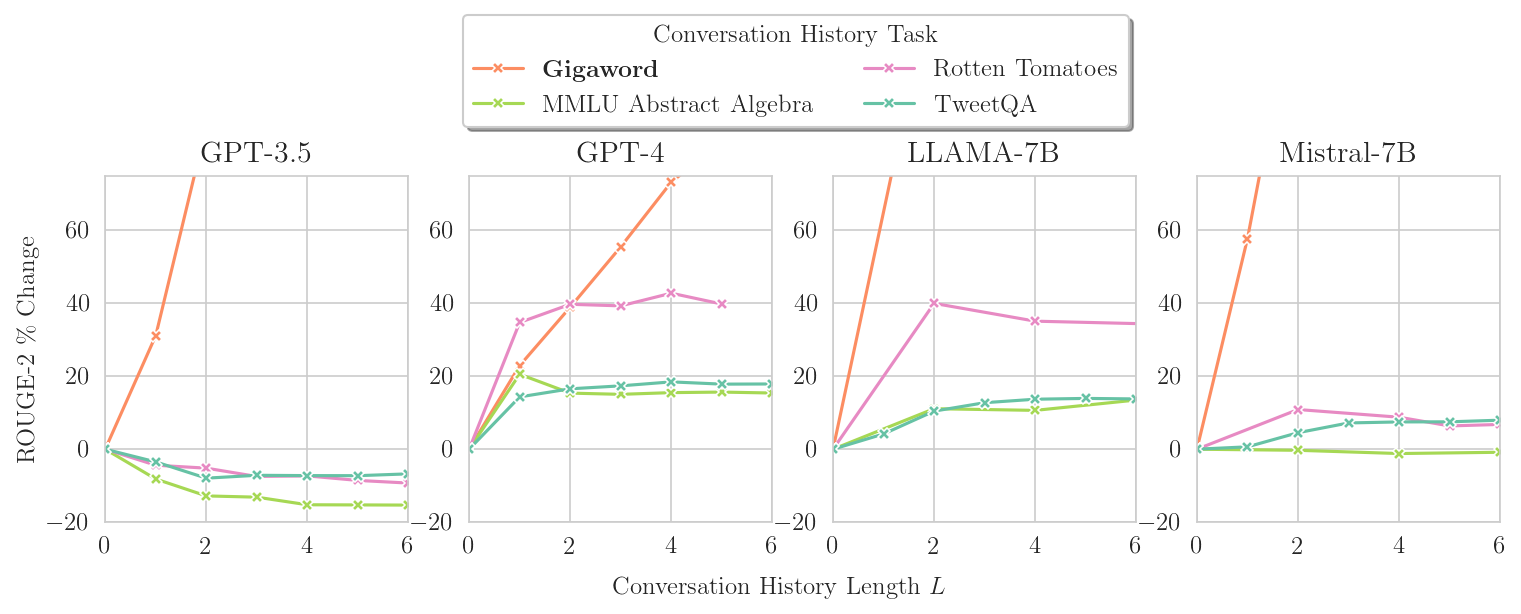

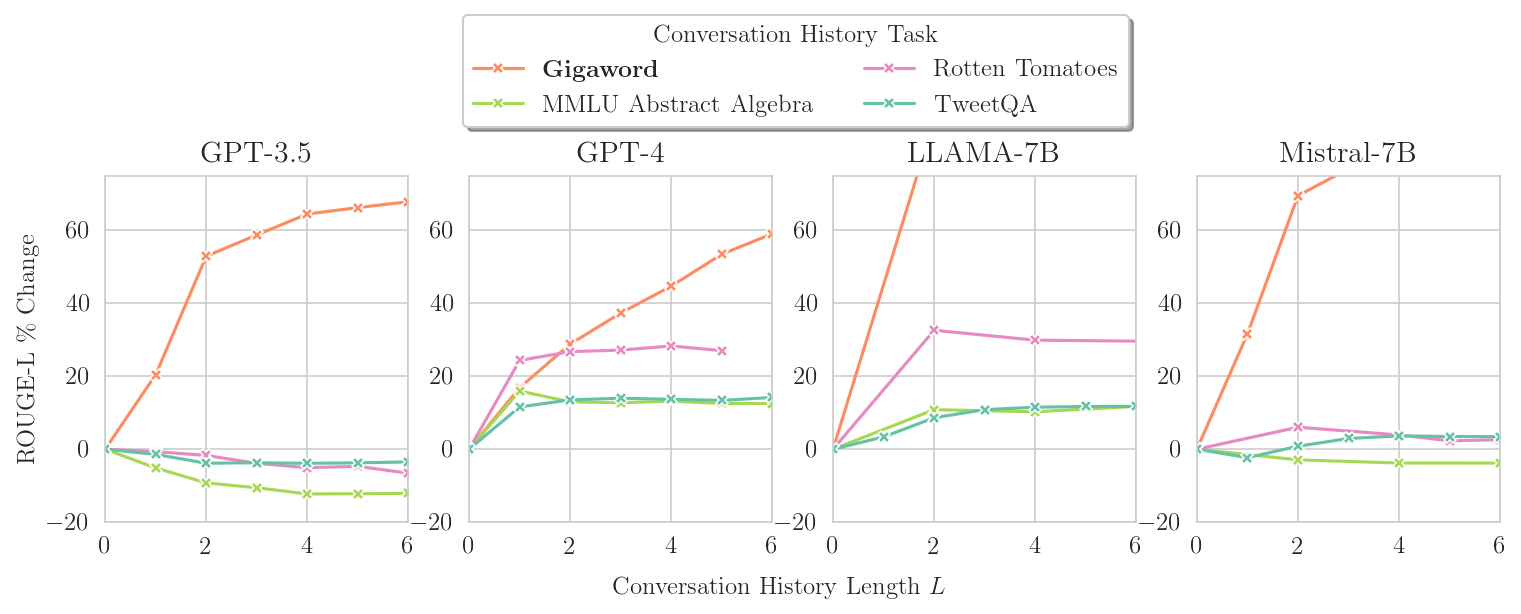

In [49]:
# Plot percentage change in metrics (1 graph per metric)

df = gw_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rouge2")
df = df_metric_pct_change(df, "rougeL")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rouge2_pct_change": r"ROUGE-2 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
}

df = df.rename(columns=labels)

for metric in labels.values():
    plot_df_metrics_per_model(
        df,
        [metric],
        save_path=Path(f"gw/{metric.split()[0]}.pdf"),
        eval_set="gigaword",
        legend_anchor=(1.14, 1.5),
        adjust_func=lambda axs: axs[0, 0].set_ylim(-20, 75),
        legend_axs=(0, 0),
    )

In [50]:
# Zero shot results table

df = gw_results_df

columns={
    r"rouge1": r"ROUGE-1",
    r"rouge2": r"ROUGE-2",
    r"rougeL": r"ROUGE-L",
}

df = df.rename(columns=columns)

# Multiply by 100
for col in columns.values():
    df[col] = df[col] * 100

zero_shot_latex_table(df, columns=columns.values(), task="gigaword", num_examples=0)

Model & {ROUGE-1} & {ROUGE-2} & {ROUGE-L} \\
\midrule
GPT-3.5 & 17.37 & 4.79 & 14.78 \\
GPT-4 & 15.76 & 4.07 & 13.34 \\
LLAMA-7B & 11.61 & 3.13 & 9.90 \\
Mistral-7B & 18.60 & 5.19 & 15.84 \\


In [51]:
len(gw_results_df[gw_results_df["base_likelihood"].notna()])

6

## Evaluate on Dailymail Set

In [52]:
dm = DailymailDataLoader()
dm_reference_data = dm.load_test_reference()
dm_results = get_results_for_evalset("dailymail", dm_reference_data, use_cached=False)
# convert to dataframe
dm_results_df = pd.DataFrame.from_records(dm_results)
# df = df.sort_values("num_examples")
dm_results_df.head()


Removing large training set examples
Original training set size:  287113
New Training set size:  258269
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3/iterative/base_probabilities.pkl
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6/iterative/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_4/iterative/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_2/iterative/base_probabilities.pkl
Skipping ../experime

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples,base_likelihood
0,0.346095,0.145672,0.226241,0.290299,813.963,mistral-7b,dailymail,3,None
1,0.343961,0.143357,0.224898,0.289263,881.994,mistral-7b,dailymail,6,None
2,0.343124,0.139915,0.220715,0.280810,778.065,mistral-7b,dailymail,0,None
3,0.346265,0.144308,0.227062,0.291889,887.419,mistral-7b,dailymail,4,None
4,0.342948,0.146287,0.225588,0.288165,909.117,mistral-7b,dailymail,2,None


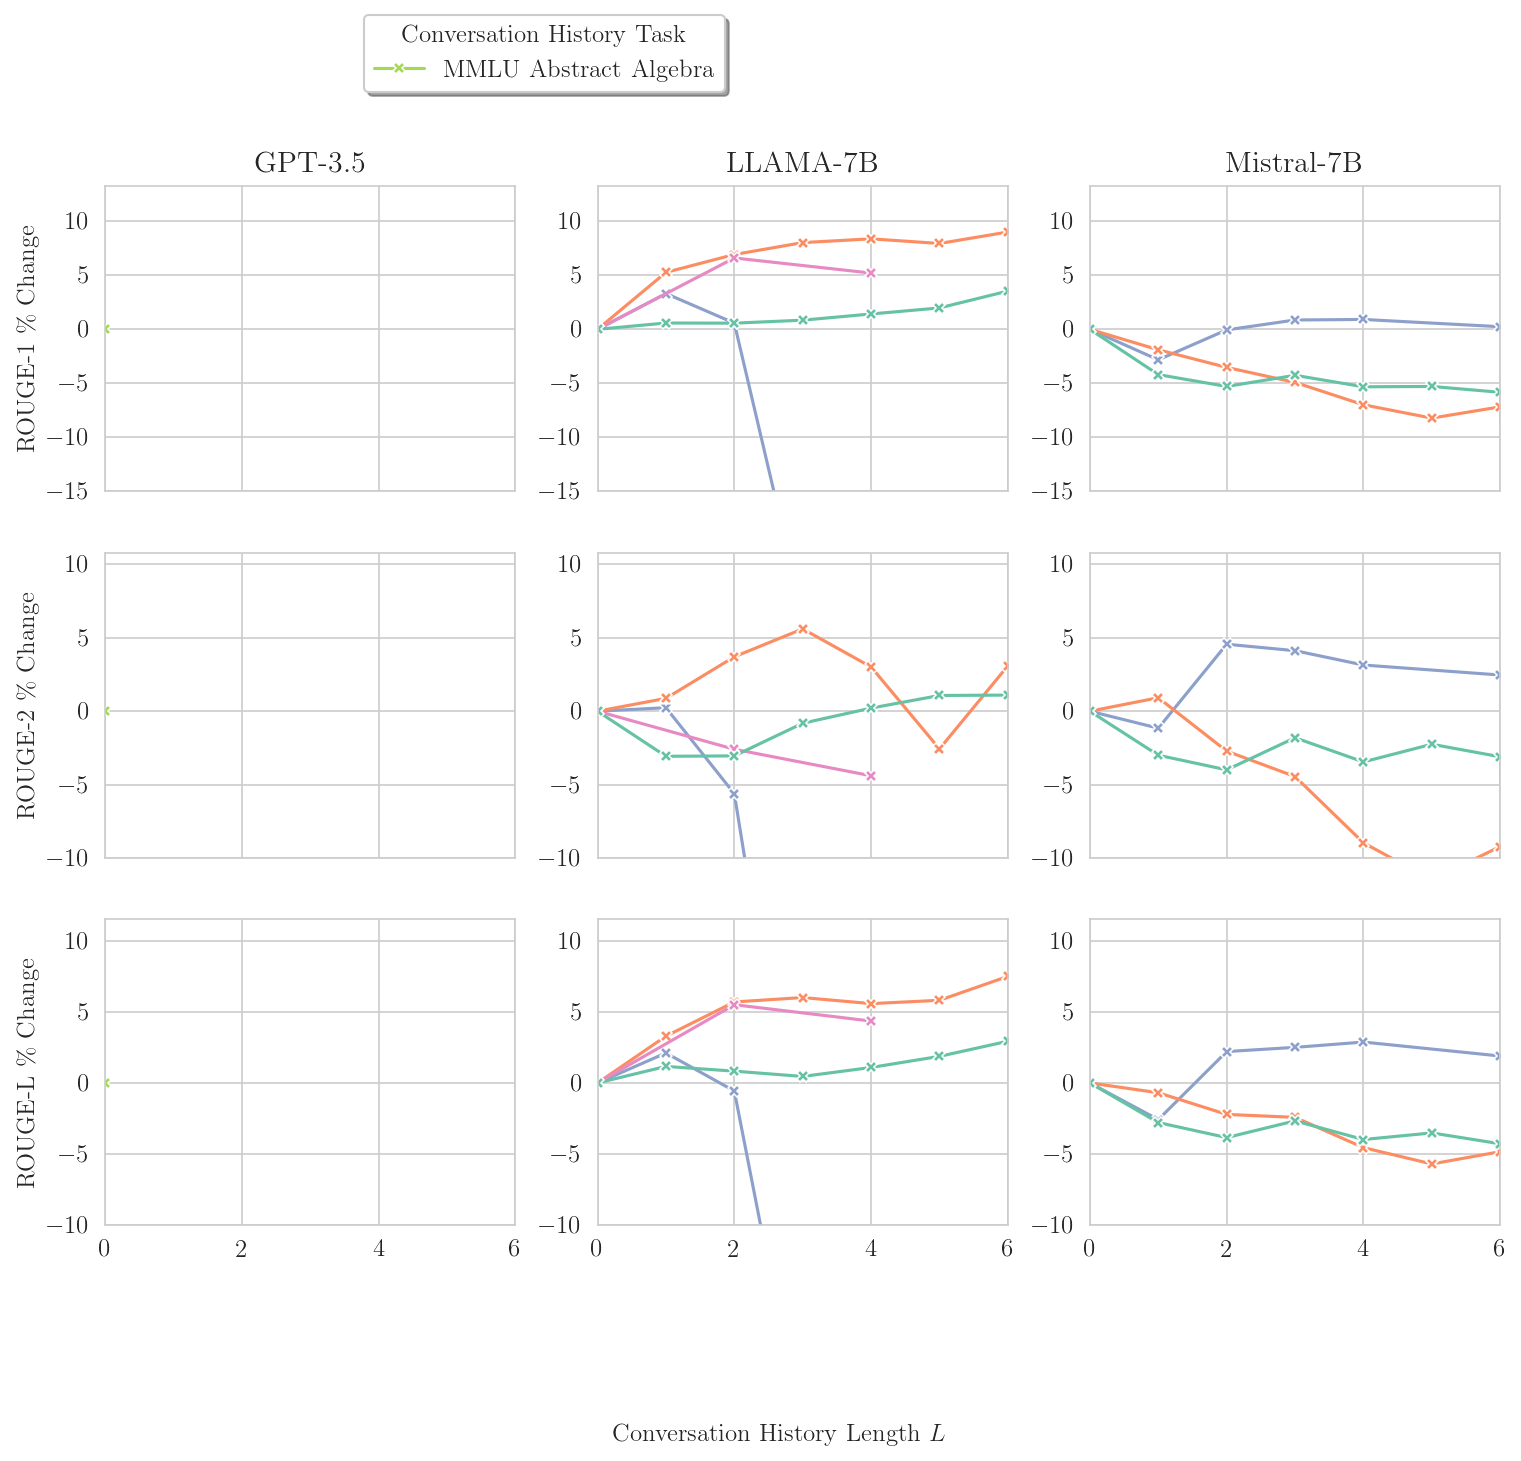

In [53]:
# Plot percentage change in metrics

df = dm_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rouge2")
df = df_metric_pct_change(df, "rougeL")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rouge2_pct_change": r"ROUGE-2 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
}

df = df.rename(columns=labels)
plot_df_metrics_per_model(
  df, 
  labels.values(), 
  # save_path=Path("dm_metrics.pdf"), 
  eval_set="dailymail",
  legend_anchor=(0.6, 1.6),
  adjust_func=lambda axs: (
    axs[0, 0].set_ylim(-15, None), 
    axs[1, 0].set_ylim(-10, None), 
    axs[2, 0].set_ylim(-10, None)
  ), 
  legend_axs=(0,0)
)

## % change vs sensitivity

- We investigate the correlation between performance change vs sensitivity. 
- There is good correlation, but it is not quantifiable as the scales need to be re-normalised between experiments

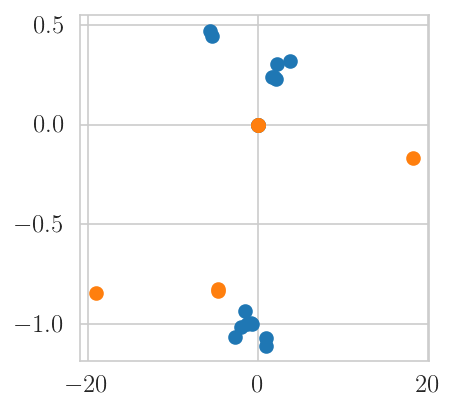

In [46]:
fig, axs = plt.subplots(figsize=(3,3))

df = rt_results_df
# remove rt
df = df[df["incontext_set"] != "rotten_tomatoes"]

axs.scatter(df["acc_pct_change"], df["exp_ref"])

df = aa_results_df
# remove mmluaa
df = df[df["incontext_set"] != "mmluaa"]

axs.scatter(df["acc_pct_change"], df["exp_ref"])